# Семинар 3: Классификация изображений

## Вступление
Сегодня мы перейдём чуть более сложным данным и архитектурам для классификации изображений.

### План семинара
1. Обучаем свёрточную сеть для задачи классификации изображений и смотрим на полученные фильтры свёрточных слоёв
2. Разбираемся с тем, что такое аугментации и зачем они нужны
3. Узнаём про способы регуляризации и нормализации при обучении нейронных сетей


In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm
import time

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Обучаем свёрточную сеть для задачи классификации изображений

Сегодня будем работать с датасетом [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), в котором содержатся изображения 10 классов (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) размером 32 на 32 пикселя с тремя каналами. В тренировочной выборке 50000 изображений, а в тестовой 10000. Загрузим его аналогично тому, как мы загружали MNIST на предыдущих занятиях.

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=transform
)
cifar_val = torchvision.datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train, batch_size=32, shuffle=True, num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val, batch_size=32, shuffle=False, num_workers=4
)

100%|██████████| 170M/170M [00:01<00:00, 94.1MB/s]


In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

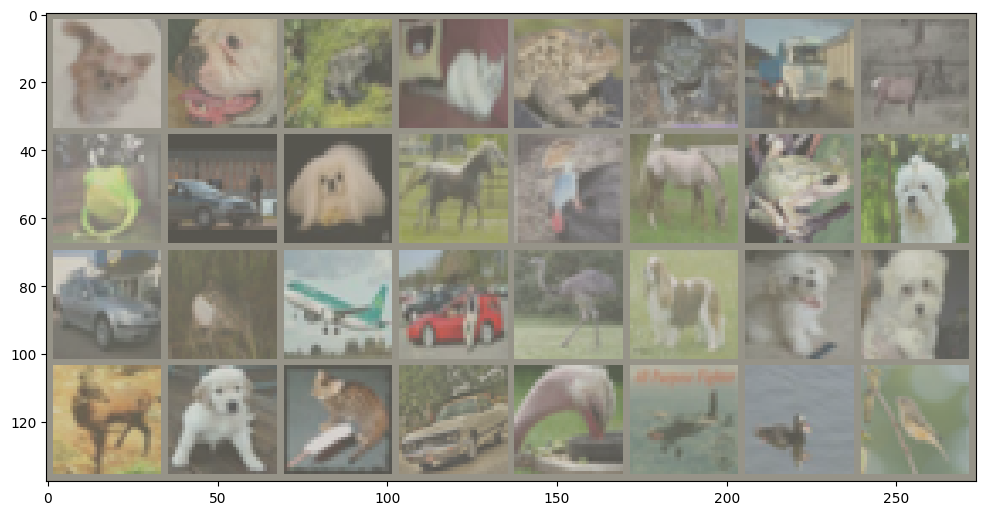

In [ ]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

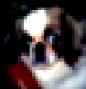

In [ ]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [ ]:
def plot_time(time_log):
    plt.figure()
    plt.title("Epoch time (seconds)")
    plt.plot(range(1, len(time_log) + 1), time_log, marker="o", c="red")
    plt.xlabel("Epoch")
    plt.ylabel("Time, sec")
    plt.grid()
    plt.show()

### Задание 1. VGG
В качестве бейзлайна постройте следующую архитектуру из 1 VGG блока:

1) VGG блок с 16 каналами:
* свёрточный слой с 16 выходными каналами и ядром 3x3, паддингом и нелинейностью ReLU
* свёрточный слой с 16 выходными каналами и ядром 3x3, паддингом и нелинейностью ReLU
* Max pooling c ядром 2x2 и шагом 2

2) Полносвязный слой с 128 выходами и нелинейностью ReLU

3) Полносвязный слой с 10 выходами

In [ ]:
class ModelBaseline(nn.Module):
    def __init__(self):
        super(ModelBaseline, self).__init__()

        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Полносвязные слои
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.vgg(x)
        x = self.fc(x)
        return x

In [ ]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    epoch_time_log = []  # ⬅️ список для хранения времени по каждой эпохе

    for epoch in range(n_epochs):
        epoch_start = time.time()  # старт замера времени

        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(
            train_dataloader, desc=f"Training, epoch {epoch}", leave=False
        ):
            imgs, labels = imgs.to(device), labels.to(device)

            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # log loss
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
            )
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append(
                (pred_classes == labels.cpu()).sum() / labels.cpu().shape[0]
            )

        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(
                val_dataloader, desc=f"Validating, epoch {epoch}", leave=False
            ):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
                )

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum()
            / val_epoch_true_hits.size(0)
            / val_dataloader.batch_size
        )

        # засечём время эпохи
        epoch_time = time.time() - epoch_start
        epoch_time_log.append(epoch_time)

        # вывод графиков
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")
        plot_time(epoch_time_log)  # ⬅️ новый график времени

        # печать статистики
        print(f"Epoch {epoch+1}/{n_epochs}")
        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:",
            (
                train_epoch_true_hits.sum()
                / train_epoch_true_hits.size(0)
                / train_dataloader.batch_size
            ).item(),
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (
                val_epoch_true_hits.sum()
                / val_epoch_true_hits.size(0)
                / val_dataloader.batch_size
            ).item(),
        )
        print(f"Epoch time: {epoch_time:.2f} sec")

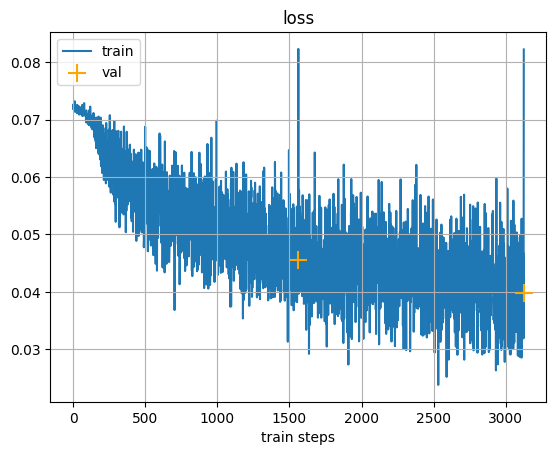

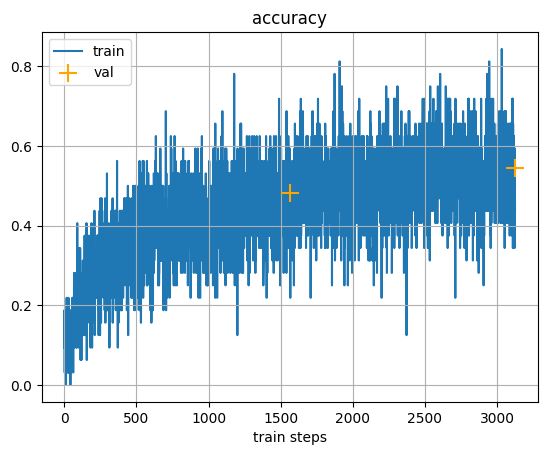

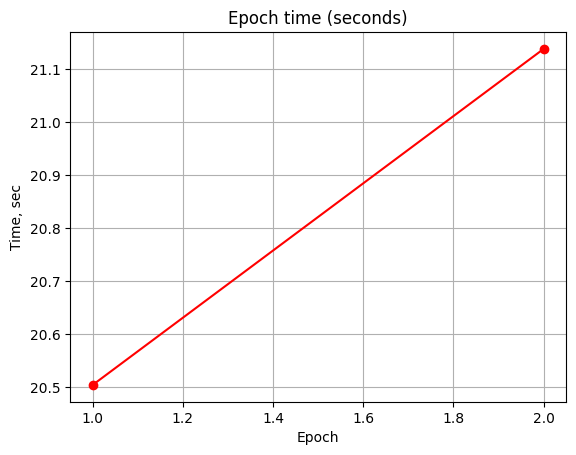

Epoch 2/2
Train loss: 0.04267236590385437
Train acc: 0.5121961236000061
Val loss: 0.03986484929919243
Val acc: 0.5442292094230652
Epoch time: 21.14 sec


In [ ]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 3)

### Визуализируем параметры сети

In [ ]:
#Запустите эти ячейки при работе из колаба
!wget https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2022/seminars/sem03/filter_viz.py

import sys
from google.colab import drive

drive.mount("/content/gdrive")
sys.path.append("/content/gdrive/My Drive")

--2025-09-22 15:06:10--  https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2022/seminars/sem03/filter_viz.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3188 (3.1K) [text/plain]
Saving to: ‘filter_viz.py’

filter_viz.py       100%[===================>]   3.11K  --.-KB/s    in 0s      

2025-09-22 15:06:11 (58.1 MB/s) - ‘filter_viz.py’ saved [3188/3188]

Mounted at /content/gdrive


In [ ]:
from filter_viz import plot_filters

In [ ]:
model_baseline.cpu()

ModelBaseline(
  (vgg): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

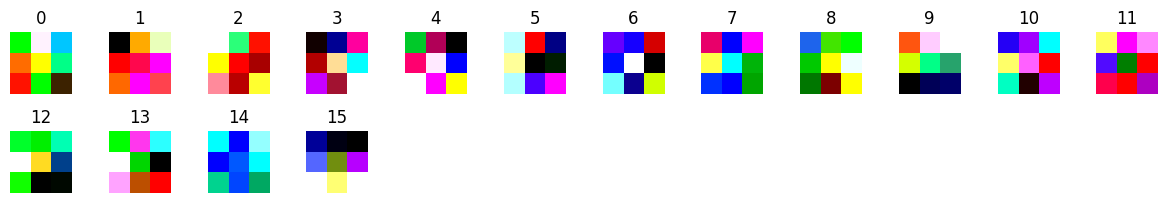

In [ ]:
plot_filters(model_baseline.vgg[0], single_channel=False)

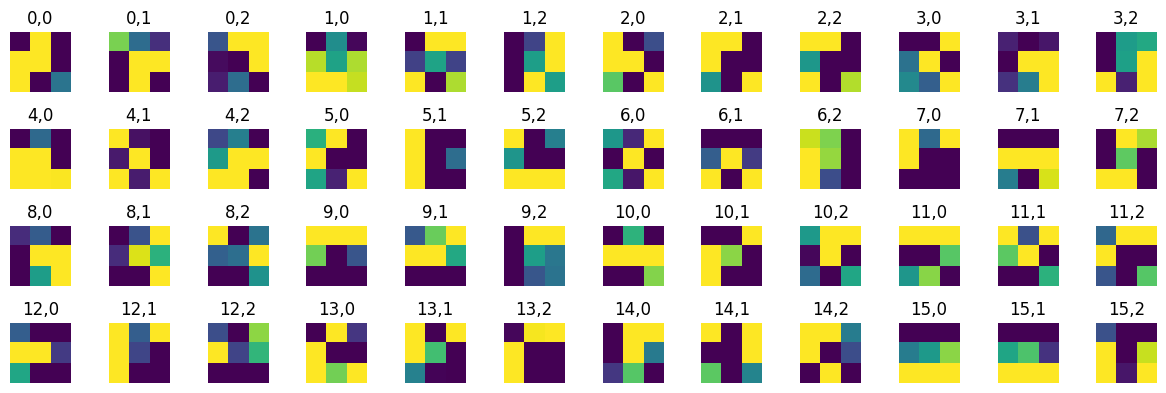

In [ ]:
plot_filters(model_baseline.vgg[0], single_channel=True)

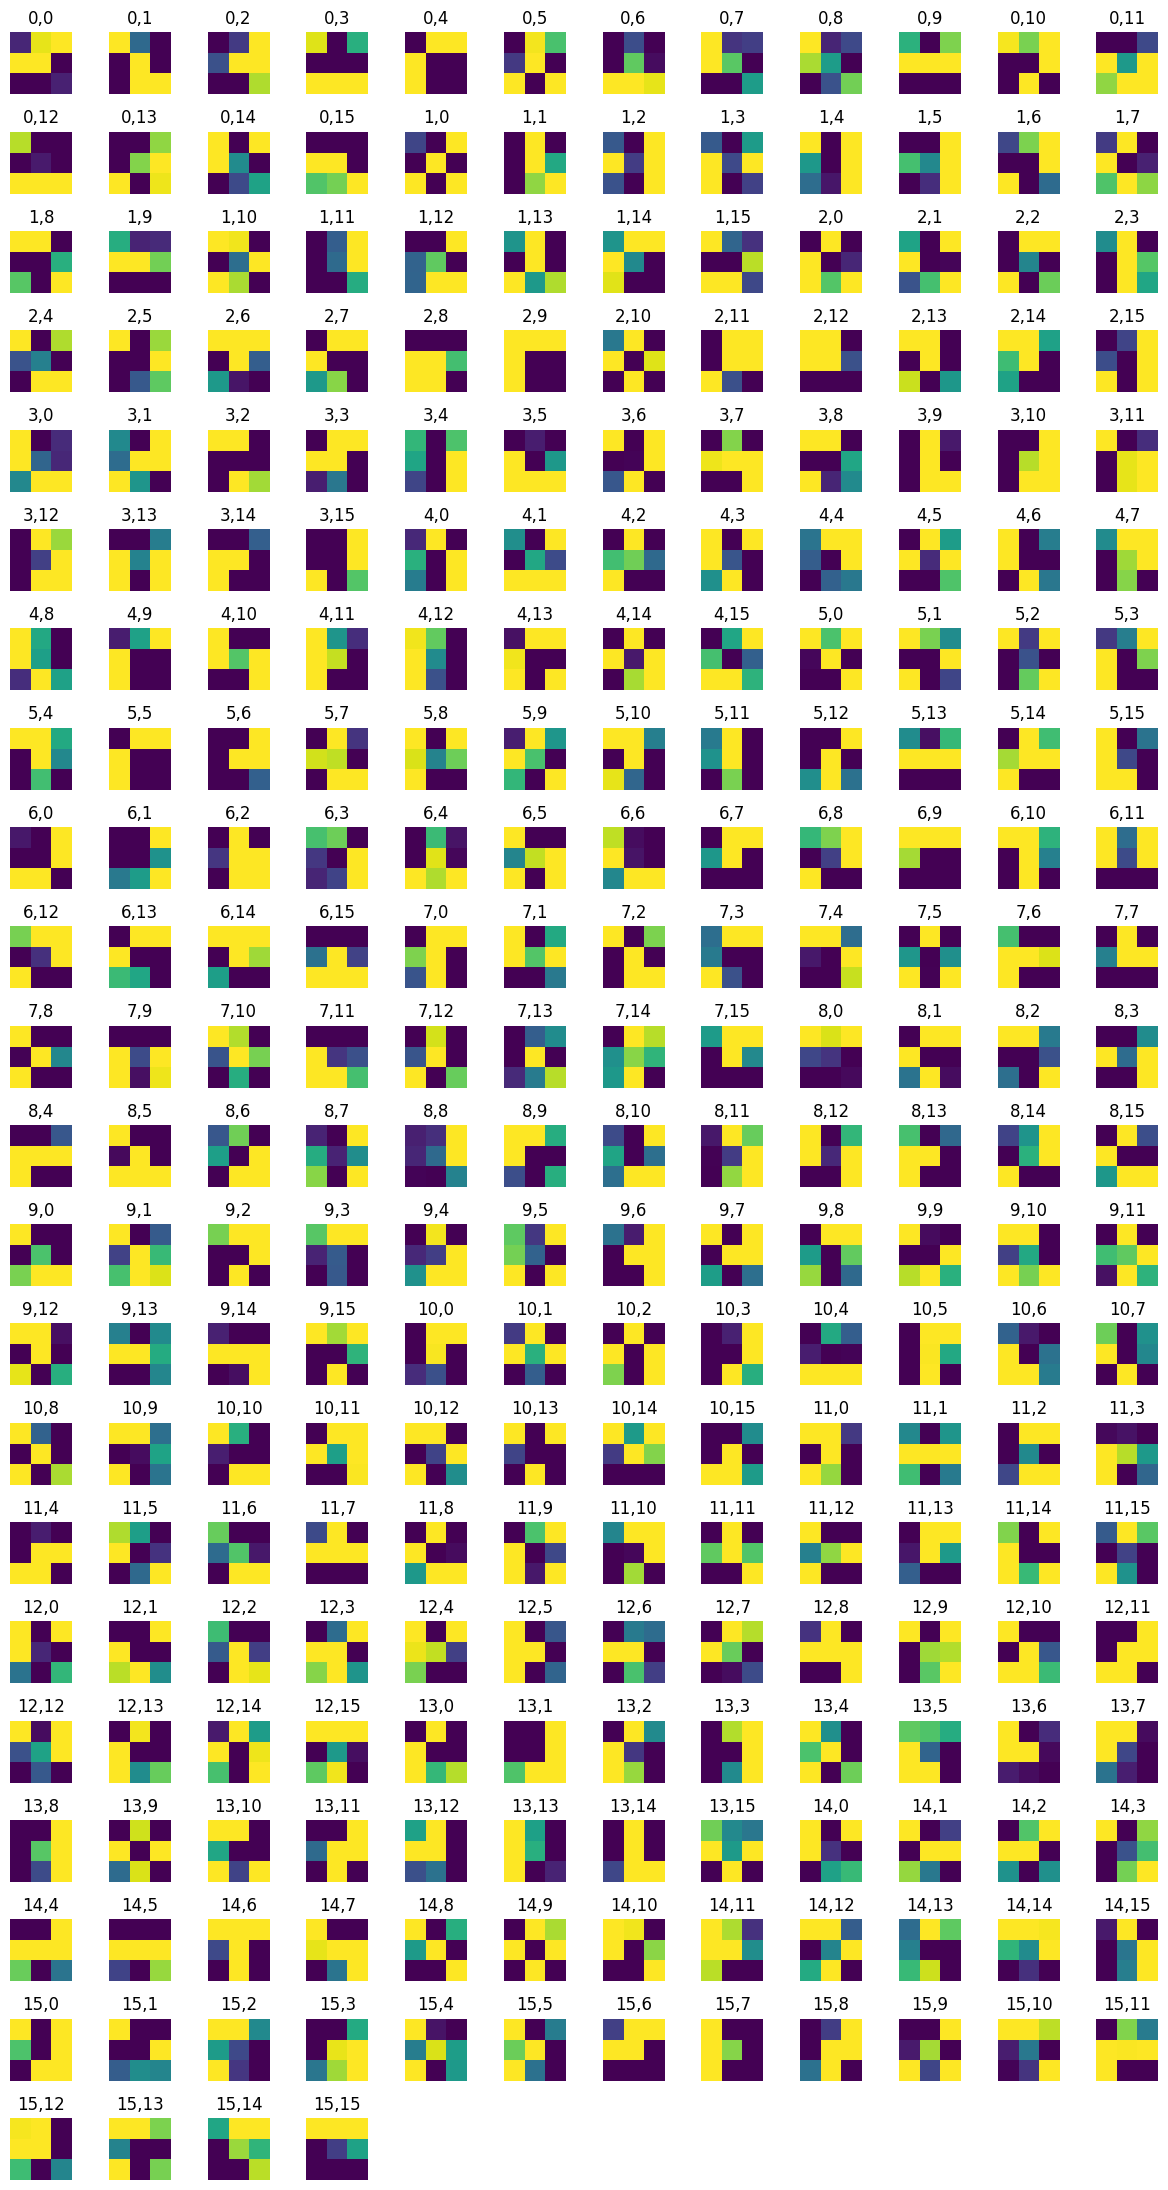

In [ ]:
plot_filters(model_baseline.vgg[2], single_channel=True)

Как вы думаете, что значат квадратики разных цветов выше?

Там, где (single_channel=False), мы видим фильтры нулевого свёрточного слоя. Каждый участок фильтра настроен на поиск конкретного цвета.

В остальных двух картинках также видим фильтры, но в разбивке по каналам. Здесь каждый цвет (от фиолотевого до жёлтого) - интенсивность конкретного RGB цвета на конкретном участке.

### Задание 2. Активации

Поэкспериментируйте с функциями активации сети. Попробуйте заменить ReLU на LeakyReLU, ELU или SELU. Как замена влияет на качество и скорость сходимости?

Почитать про разные функции активации можно [здесь](https://ml-explained.com/blog/activation-functions-explained) и в [документации PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

In [ ]:
class ModelBaseline(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super(ModelBaseline, self).__init__()

        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            activation(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            activation(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16 * 16, 128),
            activation(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.vgg(x)
        x = self.fc(x)
        return x


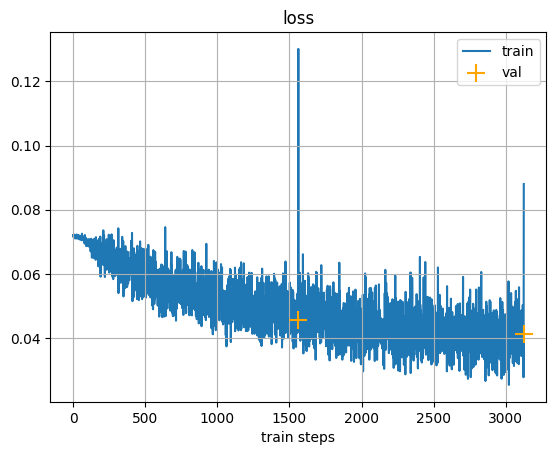

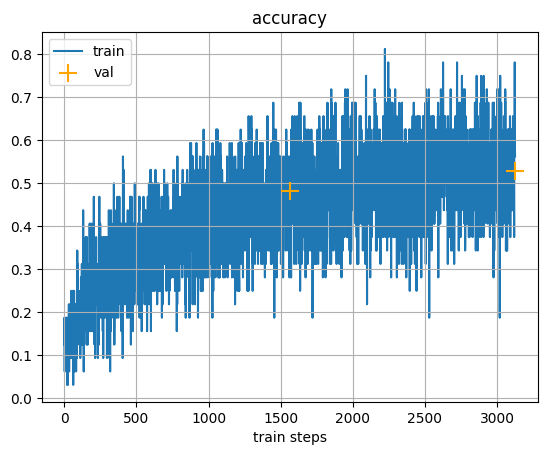

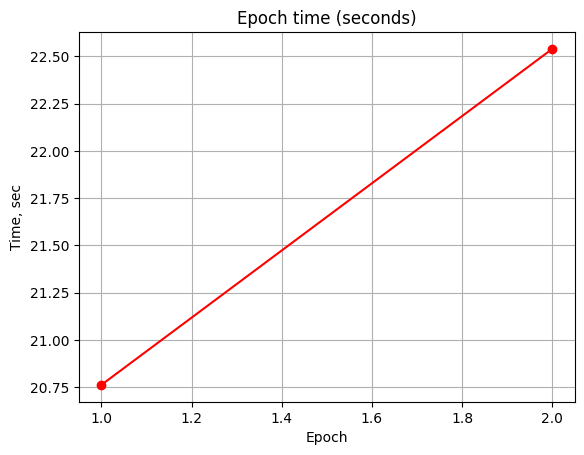

Epoch 2/2
Train loss: 0.04272694140672684
Train acc: 0.5107565522193909
Val loss: 0.04124004393815994
Val acc: 0.5280551314353943
Epoch time: 22.54 sec


In [ ]:
model = ModelBaseline(activation=nn.ReLU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 3)

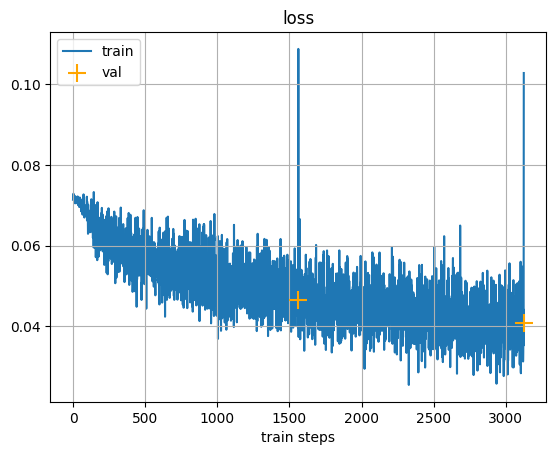

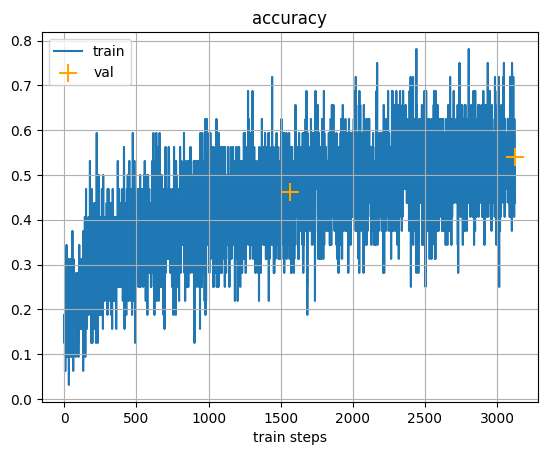

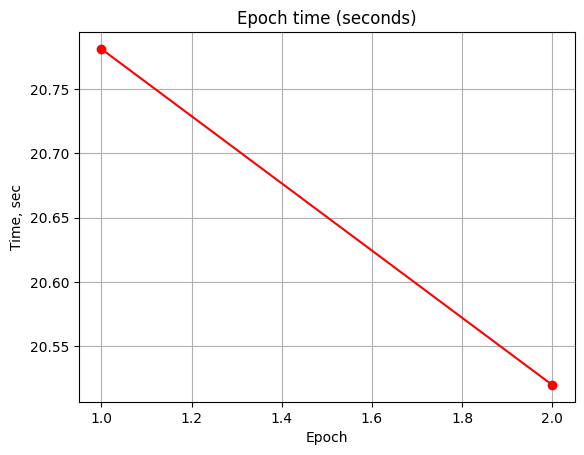

Epoch 2/2
Train loss: 0.04341227188706398
Train acc: 0.5021793246269226
Val loss: 0.04070277884602547
Val acc: 0.5400359630584717
Epoch time: 20.52 sec


In [ ]:
model = ModelBaseline(activation=nn.LeakyReLU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 3)

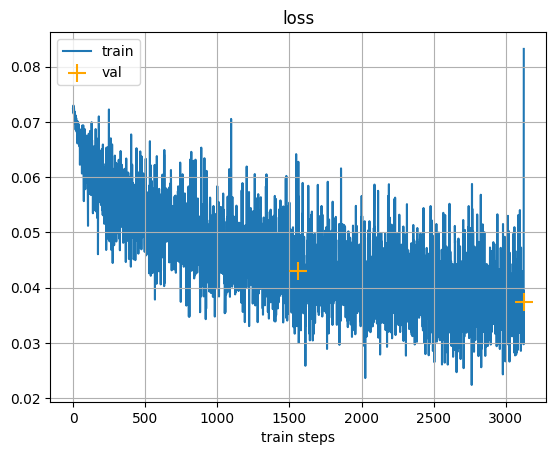

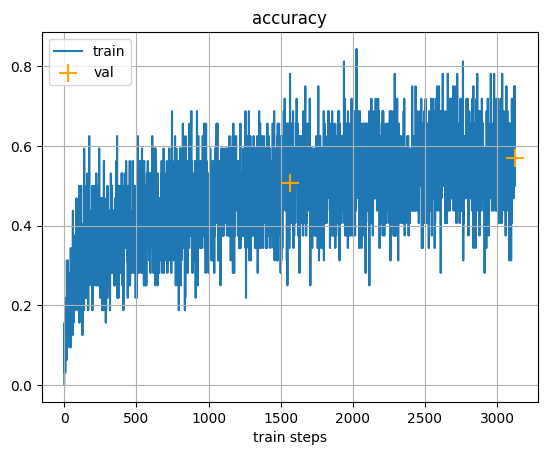

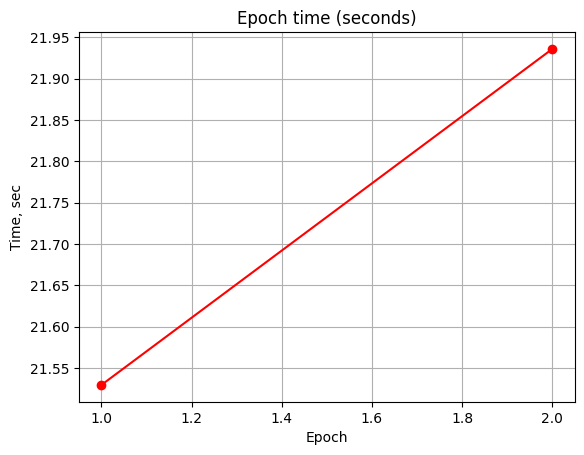

Epoch 2/2
Train loss: 0.040557876229286194
Train acc: 0.5360284447669983
Val loss: 0.03749597445130348
Val acc: 0.5691893100738525
Epoch time: 21.94 sec


In [ ]:
model = ModelBaseline(activation=nn.ELU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 3)

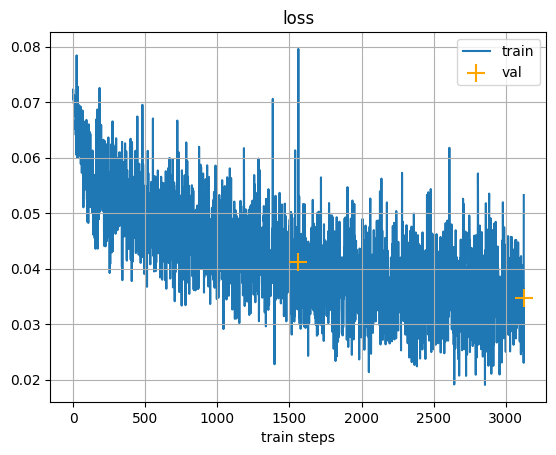

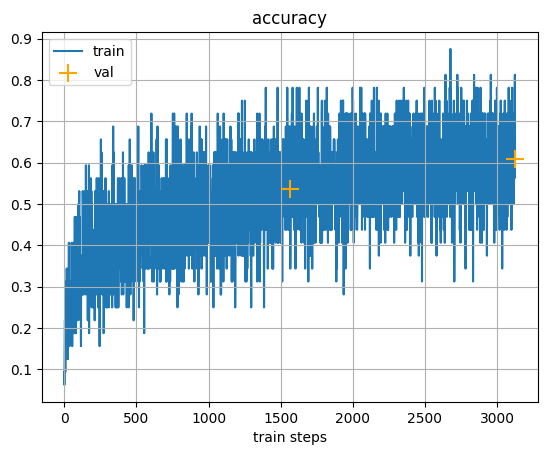

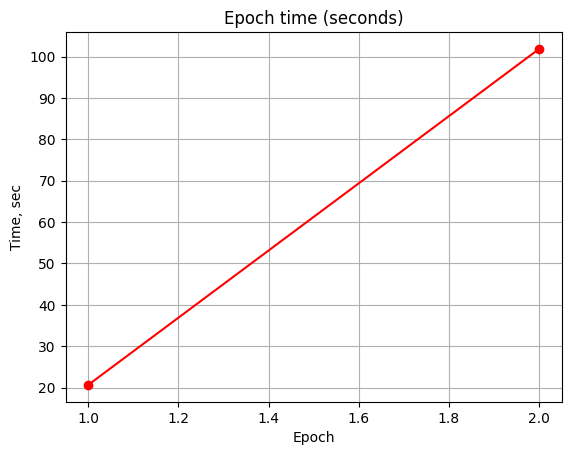

Epoch 2/2
Train loss: 0.03654409572482109
Train acc: 0.588731586933136
Val loss: 0.03473973646759987
Val acc: 0.6086261868476868
Epoch time: 101.87 sec


In [ ]:
model = ModelBaseline(activation=nn.SELU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 3)

## 2. Аугментации

Аугментация данных - очень мощный процесс, который позволяет увеличить количество тренировочных данных. С помощью поворотов, отражения, добавления шума, сдвигов и других преобразований, картинка немного меняется, однако сохраняет свою прежнюю метку. С помощью функции Compose можно объединять несколько трансформаций изображения, а потом применять их при чтении датасета. Полный список аугментаций доступен [тут](https://pytorch.org/vision/stable/transforms.html). Изучите его и поэкспериментируйте с различными трансформациями изображения.

Довольно мощным и эффективным инструментом для аугментаций на картинках является библиотека `albumentations`. В этом курсе мы не будем её рассматривать, но можете поэкспериментировать с ней сами.

In [ ]:
import PIL

transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=0.05, saturation=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

base_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=transform
)
cifar_val = torchvision.datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=base_transform
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train, batch_size=32, shuffle=True, num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val, batch_size=32, shuffle=False, num_workers=4
)

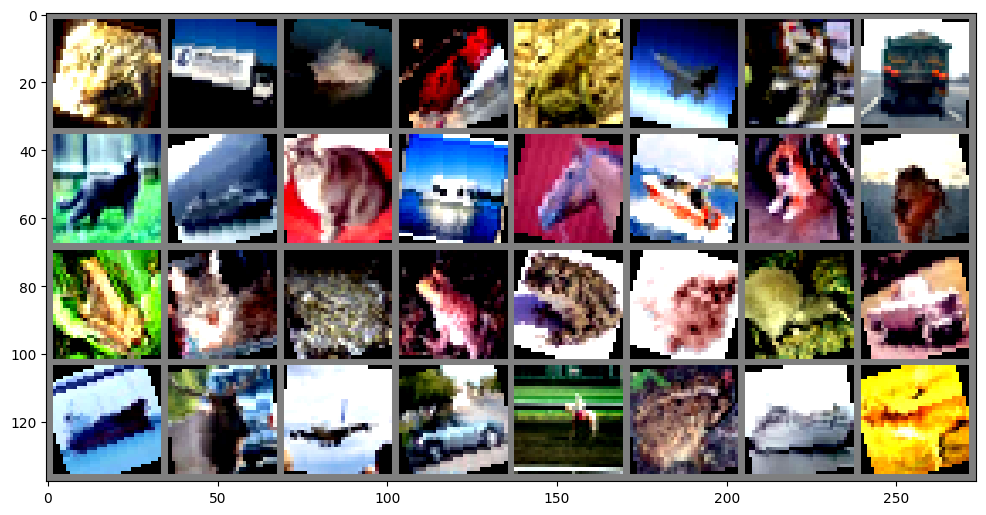

In [ ]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

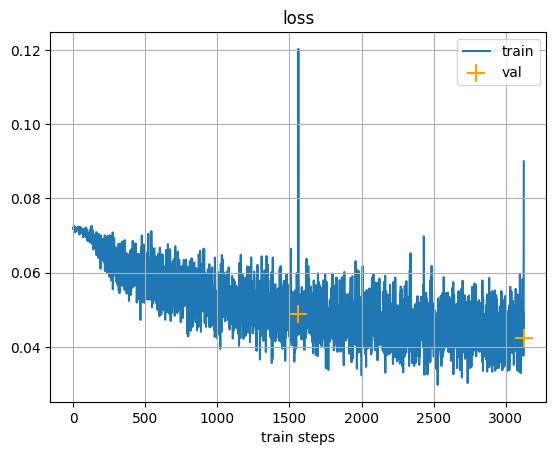

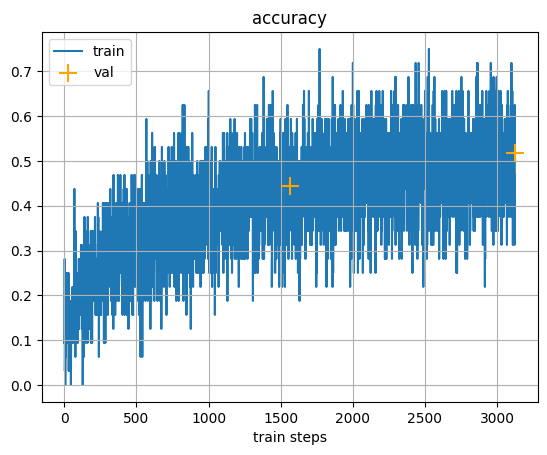

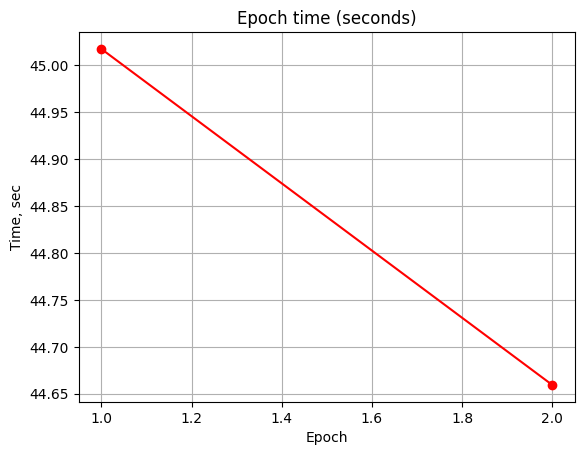

Epoch 2/2
Train loss: 0.04587842524051666
Train acc: 0.4723288416862488
Val loss: 0.04231387376785278
Val acc: 0.5170726776123047
Epoch time: 44.66 sec


In [ ]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 3)

## 3. Регуляризации и нормализации в нейронных сетях

### Dropout
Если сеть имеет сложную архитектуру, то возможно переобучение - процесс, в котором модель слишком сильно подстраивается под тренировочную выборку и потом дает заниженное качество на тестовой. Для борьбы с этим можно использовать Dropout. Идея метода очень проста. На тренировке `torch.nn.Dropout` зануляет каждый элемент входного тензора с вероятностью $p$. На инференсе ничего не зануляется, но, для того, чтобы сохранить масштаб выходов сети, все элементы входного тензора делятся на $1 - p$.

![Dropout](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem03/static/dropout.png?raw=1)

Для стабилизации и ускорения сходимости обучения часто используют батч нормализацию. В **PyTorch** она тоже имплементирована в виде слоя — [`torch.nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Обычно батч нормализацию вставляют между смысловыми блоками нейронной сети, чтобы сохранять распределение данных на всём forward pass. Обратите внимание, что на тренировке выборочные среднее и стандартное отклонение каждый раз заново вычисляются по батчу, а также у слоя есть обучаемых два числовых параметра на каждый канал входного тензора. На инференсе в качестве среднего и дисперсии используются оценки, полученные скользящими средними во время тренировки.

![Batch Norm](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem03/static/batch_norm.png?raw=1)

Давайте обучим новую сеть, в которой будет 3 VGG блока и добавим в неё батч нормализацию и дропаут.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # nn.Dropout(0.2),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # nn.Dropout(0.2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
)

In [ ]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

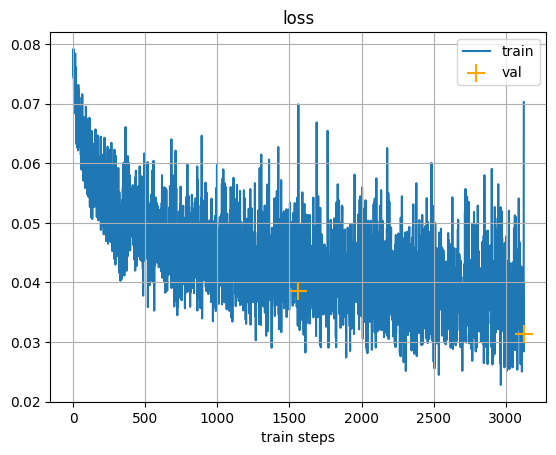

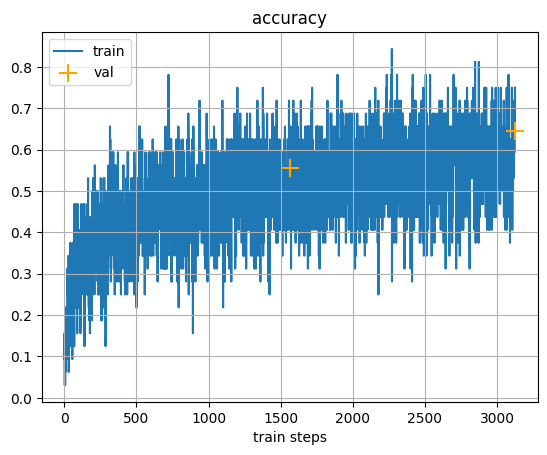

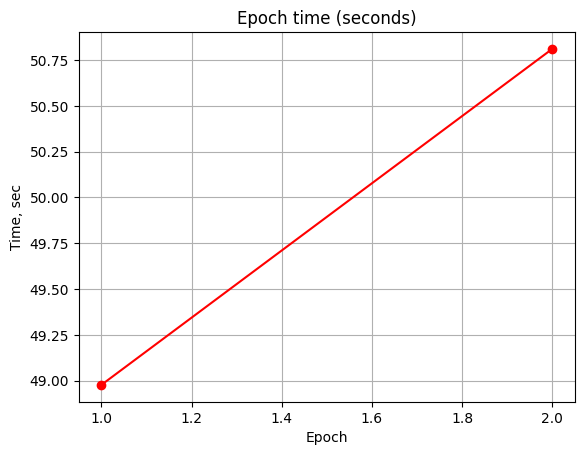

Epoch 2/2
Train loss: 0.03934900835156441
Train acc: 0.5525631904602051
Val loss: 0.031413570046424866
Val acc: 0.6444688439369202
Epoch time: 50.81 sec


In [ ]:
train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 3)

### Задание 1. Реализация Spatial Dropout

Обычный Dropout зануляет отдельные нейроны, но при использовании свёрток мы бы хотели пойти дальше и занулять целые каналы (почему?). Реализуйте Spatial Dropout, который позволит это сделать.

In [ ]:
class SpatialDropout(nn.Module):
    def __init__(self, p=0.2):
        super(SpatialDropout, self).__init__()
        self.p = p

    def forward(self, x):
        if not self.training or self.p == 0.0:
            # в режиме eval() или p= 0 возвращаем как есть
            return x

        # x имеет форму [N, C, H, W]
        N, C, H, W = x.shape

        # Создаём маску: какие каналы обнуляем
        # Берём для каждой картинки в батче случайный вектор длины C
        # shape: [N, C, 1, 1] -> потом будет broadcast на H и W
        mask = (torch.rand(N, C, 1, 1, device=x.device, dtype=x.dtype) > self.p).float()

        # Чтобы сохранять ожидаемое значение (как и в обычном Dropout),
        # оставшиеся каналы умножаем на масштаб 1/(1-p).
        return x * mask / (1.0 - self.p)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    SpatialDropout(0.2),   # Вот тут!

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    SpatialDropout(0.3),   # Ещё один, чуть сильнее

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    SpatialDropout(0.4),   # Можно добавлять глубже

    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),  # здесь оставляем обычный Dropout для полносвязных
    nn.Linear(128, 10),
)

In [ ]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

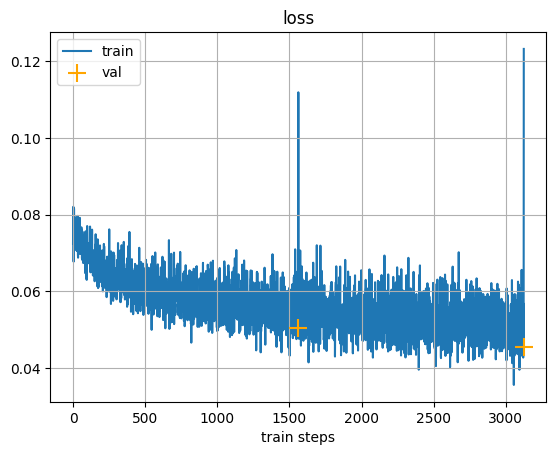

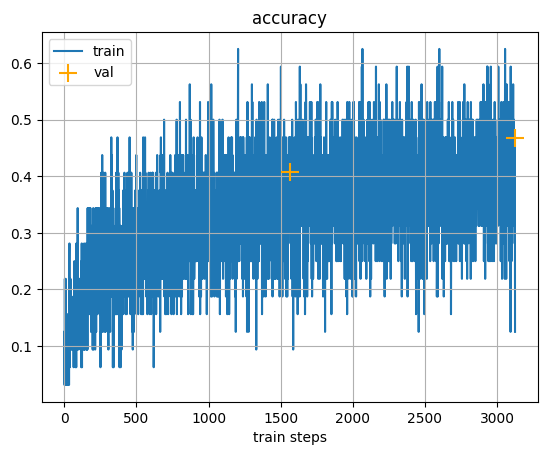

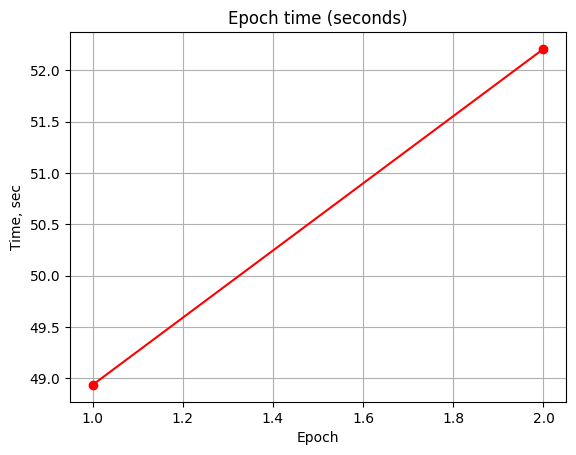

Epoch 2/2
Train loss: 0.05289747193455696
Train acc: 0.37913867831230164
Val loss: 0.04546813666820526
Val acc: 0.4681509733200073
Epoch time: 52.21 sec


In [ ]:
train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 3)